# Pulizia dati
Il seguente programma permette di individuare ed eliminare i momenti di pause tra una traccia e l'altra.
Restituisce come risultato gli indici delle tracce.


In [28]:
# impor the pandas library to read csv file and 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np

In [432]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

f1 = "20200805_075428_MWALK_#0001.csv"
f2 = "20200805_084714_MWALK_#0001.csv"
data = pd.read_csv("./input/{}".format(f1), 
                      sep=';',      # define the column separator as ";" instead of ,
                      skiprows=21,  # skip the first 21 row
                      header=0,     # define the header where the column names are defined 
                      index_col=0   # set the timestamp as the row identifier
                 )
# delete the space in the column name. e.g. From " B1x[nT]" to "B1x[nT]"
data.columns = data.columns.str.replace(' ', '')

# print first 4 row in the dataset
#print(data.head(2))

# print only the column 
#print(data['AccX[g]'])

#print(data.iloc[[1]])
raw = data['AccX[g]']
d = raw[0:100]
print(d)

noWalking = d.between(-1.05,-0.95)
#print(noWalking)
noWalking = pd.Series(data=[0 if x == True else 1 for x in noWalking], index=noWalking.index) 
noWalkingString = noWalking.astype(str).str.cat()
print(noWalkingString)

i = []
for match in re.finditer("10", noWalkingString):
    s = match.start() 
    e = match.end()
    
    idx = data.index[s + 1]
    i.append(idx)
    
    print("Stop walk init at", s, " value ", idx)
    #stopWalkinIndexes.append(s + 1)

for idx in i:
    print("index", idx)
    print(data.iloc[idx])

Timestamp [ms]
0     -0.925
5     -0.941
10    -0.941
15    -0.957
20    -0.957
       ...  
475   -1.051
480   -1.051
485   -1.026
490   -1.026
495   -1.013
Name: AccX[g], Length: 100, dtype: float64
1110000000000000000000000000000000000000000000000000000000000000000000000000000000000000001111111000
Stop walk init at 2  value  15
Stop walk init at 96  value  485
index 15
B1x[nT]                      26328.800
B1y[nT]                     -35811.200
B1z[nT]                      -8375.830
B2x[nT]                      26217.590
B2y[nT]                     -35622.270
B2z[nT]                      -9244.470
AccX[g]                         -0.968
AccY[g]                          0.090
AccZ[g]                         -0.184
Temp[Deg]                       35.000
Latitude[DecimalDegrees]         0.000
Longitude[DecimalDegrees]        0.000
Altitude[m]                      0.000
Satellites                       0.000
Quality                          0.000
GPSTime                          0.000
U

## functions to search stops between traces

[(95996, 105181), (108796, 122627), (161167, 176248), (178833, 194988), (232464, 245864), (249094, 258514), (298325, 312280), (314760, 326740), (366576, 381701), (383771, 396496), (442462, 474058), (476863, 499593), (542554, 553279), (555534, 566109), (607475, 623965), (627930, 638605), (685906, 702232), (705642, 714627)]
Timestamp [ms]
539989   -1.067
539994   -1.067
539999   -1.049
540004   -1.049
540009   -1.026
          ...  
585890   -1.272
585895   -1.272
585900   -1.292
585905   -1.277
585910   -1.277
Name: AccX[g], Length: 9185, dtype: float64
Timestamp [ms]
603990   -1.036
603995   -1.022
604000   -1.022
604005   -1.010
604010   -1.010
          ...  
673121   -1.008
673126   -1.008
673131   -1.026
673136   -1.026
673141   -1.052
Name: AccX[g], Length: 13831, dtype: float64
Series([], Name: AccX[g], dtype: float64)
Series([], Name: AccX[g], dtype: float64)
Series([], Name: AccX[g], dtype: float64)
Series([], Name: AccX[g], dtype: float64)
Series([], Name: AccX[g], dtype: floa

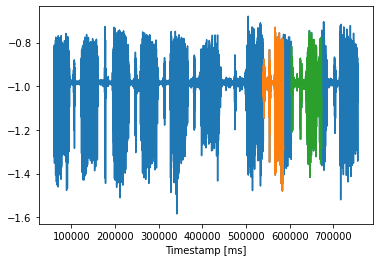

In [448]:
import matplotlib.pyplot as plt
plt.close('all')
 

acc = data['AccX[g]']
#acc = acc[80000:len(acc)-50000]
acc = acc[12000:len(acc)-2000]

acc.plot()

#b = from_acc_to_bool(acc, noAccRange=[-1.05,  -0.95])
#b.plot()

littleStops = find_all_little_stops(acc)

print(littleStops)
#print all little stops
for ls in littleStops:
    #print(acc.iloc[ls[0]:ls[1]])
    t =acc.iloc[ls[0]:ls[1]]
    t.plot()
    #acc[ls[0]:ls[1]].plot()

bigStops = obtain_big_stop_from_little_stops(littleStops)

#for bs in bigStops:
#    start = bs[0]
#    end = bs[1]
#    acc[start:end].plot()


#walks = []
#for bs in bigStops:

In [438]:
NUM_ZEROS_PATTERN = 400 #125
# tif the accelartion is between this two limit is considered 0 accelaration => no walk.
UPPER_LIMIT_NO_ACCEL = -0.93
LOWER_LIMIT_NO_ACCEL = -1.07

# Convert the array of accellation into an array of boolean, 
# where True indentify no walk (acc in the range of no accel), False means Yes walk.
def _from_acc_to_bool(dataAcc, lowerAccLimit=LOWER_LIMIT_NO_ACCEL, upperAccLimit=UPPER_LIMIT_NO_ACCEL):    
    # between this range, the accelaration is as no accelaration
    # Convert into an array that contains only True (is not walking) and False (is walking)
    # noWalking contains True if there is no acceleration (not walking) False otherwise
    noWalking = dataAcc.between(lowerAccLimit, upperAccLimit)
    
    if len(noWalking) != len(dataAcc):
        raise("ERROR; no equal length")
    
    # transform the array of boolean into an array of string 1 and 0, 
    noWalking = pd.Series(data=[0 if x == True else 1 for x in noWalking], index=noWalking.index)    
    return  noWalking

def find_all_little_stops(dataAcc, 
                        stopWalkPattern="1" + ''.join("0" for i in range(NUM_ZEROS_PATTERN)),
                        startWalkPattern=''.join("0" for i in range(NUM_ZEROS_PATTERN)) + "1"):
    
    
    dataAccWithZeroOne =  _from_acc_to_bool(dataAcc)
    # All the little stops are found by searching a specific pattern in the sequence of zero an ones.
    # A single stop is a seuqence of a stopWalk pattern followed by a startWalk pattern. 
    #     1 00000000: (stop walking pattern): a sequence of type  1 000...000     
    #     00000000 1: (start walking pattern): a sequence of type   000....0000 1 
    
    import re
    # Obtain a string of zeros and ones
    noWalkingString = dataAccWithZeroOne.astype(str).str.cat()
    
    # Create a list of indexes where occurs a stopWalk pattern
    stopWalkinIndexes = []
    for match in re.finditer(stopWalkPattern, noWalkingString):
        s = match.start() 
        e = match.end()
        start = s + 1  # add 1 beacause the pattern is 10000 but the stop init with the first 0
        # from the index of the string to the index in the dataframe
        idx = dataAcc.index[start]
        stopWalkinIndexes.append(idx)

    # Create a list of indexes where occurs a startWalk pattern
    startWalkIndexes = []
    for match in re.finditer(startWalkPattern, noWalkingString):
        s = match.start()
        e = match.end()
        end =  e -1
        idx = dataAcc.index[end]
        startWalkIndexes.append(idx)
        
    if len(startWalkIndexes) != len(stopWalkinIndexes):
            raise Exception("Impossible to find little stops. # stopwalk:{} and # startwalk:{}.".format(len(stopWalkinIndexes), len(startWalkIndexes)))

    # TODO: check that the two list are of the same length
    # Build the list of all the little stops found by zipping the stap and start indexes. 
    # E.g. zip([0,2][1,3]) = [(0,1)(2,3)]
    littleStops = list(zip(stopWalkinIndexes, startWalkIndexes))
  
    return littleStops

def obtain_big_stop_from_little_stops(lstops):
    # if there are an odd number of littleSteps, there is something wrong...
    if len(lstops) % 2 != 0:
        raise Exception("Impossibe to obtain big stop. There are an odd number of little stops")
        
    bigStops = [] # list of tuple. Each tuple contains the big stop indexes (start, stop).
   
    # obtain all the big stop, by joining the couple of little stops
    # E.g. from two little stops (0,1)(2,3) (4,5)(6,7) to  big stops (0,3), (4,7)
 
    for i in range(0, len(lstops), 2):
        if i < len(lstops):
            first = lstops[i]
            start = first[0]    # take the start of the first little stop
            if i + 1 < len(lstops):
                second = lstops[i+1]
                stop = second[1]   # take the end of the second little stop
            else:
                stop = first[0] 
            bigStops.append((start, stop))
    return bigStops
